

---
# IMPORTS


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install gym==0.25.1 > /dev/null 2>&1
!pip install box2d-py > /dev/null 2>&1
!pip3 install gym[box2d] > /dev/null 2>&1
!apt-get install -y xvfb x11-utils > /dev/null 2>&1
!pip install pyvirtualdisplay==0.2.*  > /dev/null 2>&1
!python -m pip install cma > /dev/null 2>&1
!pip install cmaes > /dev/null 2>&1 #wrapper di cma

In [ ]:
import gym
from gym.wrappers.monitoring.video_recorder import VideoRecorder
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
from IPython.display import HTML


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
import torch.optim as optim
from torch.distributions import Normal, OneHotCategorical
from torch.autograd import Variable
from torch.distributions import Categorical
from torchvision.transforms import ToTensor, Normalize, RandomRotation, RandomHorizontalFlip
import torchvision.transforms as T
from torch.multiprocessing import Process, Queue
import pickle
import cma
from cmaes import CMA
import math

gym.version.VERSION

'0.25.1'

In [ ]:
#https://www.anyscale.com/blog/an-introduction-to-reinforcement-learning-with-openai-gym-rllib-and-google
from pyvirtualdisplay import Display
display = Display(visible=False, size=(1400, 900))
_ = display.start()


In [ ]:
from base64 import b64encode
def render_mp4(videopath: str) -> str:
  """
  Gets a string containing a b4-encoded version of the MP4 video
  at the specified path.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'


In [ ]:
use_gpu = True
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")

In [ ]:
#what environment is used 
env = gym.make("CarRacing-v2")
observation, info = env.reset(seed=42, return_info=True)
conversion = ToTensor()

/usr/local/lib/python3.7/dist-packages/gym/core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


# MODELS

## VAE

In [ ]:
class Encoder(nn.Module):
    def __init__(self, hidden_channels: int, latent_dim: int, fc_size: int) -> None:
        """
        Simple encoder module

        It predicts the `mean` and `log(variance)` parameters.

        The choice to use the `log(variance)` is for stability reasons:
        https://stats.stackexchange.com/a/353222/284141
        """
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, 
                               out_channels=hidden_channels, 
                               kernel_size=4, 
                               stride=2, 
                               padding=1) 

        self.conv2 = nn.Conv2d(in_channels=hidden_channels, 
                               out_channels=hidden_channels*2, 
                               kernel_size=4, 
                               stride=2, 
                               padding=1) 

        self.conv3 = nn.Conv2d(in_channels=hidden_channels*2, 
                               out_channels=hidden_channels*4, 
                               kernel_size=4, 
                               stride=2, 
                               padding=1)  
        
        self.conv4 = nn.Conv2d(in_channels=hidden_channels*4, 
                               out_channels=hidden_channels*8, 
                               kernel_size=4, 
                               stride=2, 
                               padding=1)  
        self.conv5 = nn.Conv2d(in_channels=hidden_channels*8, 
                               out_channels=hidden_channels*16, 
                               kernel_size=4, 
                               stride=2, 
                               padding=1)            

        self.fc_mu = nn.Linear(in_features=fc_size, 
                               out_features=latent_dim)
        self.fc_logvar = nn.Linear(in_features=fc_size, 
                                   out_features=latent_dim)
            
        self.activation = nn.ReLU()

    def forward(self, x: torch.Tensor):
        """
        :param x: batch of images with shape [batch, channels, w, h]
        :returns: the predicted mean and log(variance)
        """
        x = self.activation(self.conv1(x))
        #print("conv1", x.shape)
        x = self.activation(self.conv2(x))
        #print("conv2", x.shape)
        x = self.activation(self.conv3(x))
        #print("conv3", x.shape)
        x = self.activation(self.conv4(x))
        #print("conv4", x.shape)
        x = self.activation(self.conv5(x))
        #print("conv5", x.shape)

        x = x.view(x.shape[0], -1)  #flatten
        #TODO SIGMOID E' STATO AGGIUNTO DA ME PER FARE DEI TEST
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        #x_mu = F.sigmoid( self.fc_mu(x) )
        #x_logvar = F.sigmoid(  self.fc_logvar(x) )


        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self, hidden_channels: int, latent_dim: int, fc_size: int) -> None:
        """
        Simple decoder module
        """
        super().__init__()
        self.hidden_channels = hidden_channels

        self.fc = nn.Linear(in_features=latent_dim, 
                            out_features=fc_size)

        self.conv5 = nn.ConvTranspose2d(in_channels=hidden_channels*16, 
                                        out_channels=hidden_channels*8, 
                                        kernel_size=4, 
                                        stride=2, 
                                        padding=1)
        self.conv4 = nn.ConvTranspose2d(in_channels=hidden_channels*8, 
                                        out_channels=hidden_channels*4, 
                                        kernel_size=4, 
                                        stride=2, 
                                        padding=1)
        self.conv3 = nn.ConvTranspose2d(in_channels=hidden_channels*4, 
                                        out_channels=hidden_channels*2, 
                                        kernel_size=4, 
                                        stride=2, 
                                        padding=1)
            
        self.conv2 = nn.ConvTranspose2d(in_channels=hidden_channels*2, 
                                        out_channels=hidden_channels, 
                                        kernel_size=4, 
                                        stride=2, 
                                        padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=hidden_channels, 
                                        out_channels=3, 
                                        kernel_size=4, 
                                        stride=2, 
                                        padding=1)
        
        self.activation = nn.ReLU()
        
            
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        :param x: a sample from the distribution governed by the mean and log(var)
        :returns: a reconstructed image with size [batch, 1, w, h]
        """
        #print("start deconv with", x.shape)
        x = self.fc(x)
        w_h = int( (x.size(1)/(self.hidden_channels*16) )/2) 
        x = x.view(x.size(0), self.hidden_channels*16, w_h, w_h)
        x = self.activation(self.conv5(x))
        x = self.activation(self.conv4(x))
        x = self.activation(self.conv3(x))
        x = self.activation(self.conv2(x))
        #print("deconv2", x.shape)
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        #print("deconv1", x.shape)
        return x
        

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, hidden_channels: int, latent_dim: int, fc_size=4608):
        super().__init__()
        self.encoder = Encoder(hidden_channels=hidden_channels, 
                               latent_dim=latent_dim, fc_size=fc_size)
        self.decoder = Decoder(hidden_channels=hidden_channels, 
                               latent_dim=latent_dim, fc_size=fc_size)
    

    
    def latent_sample(self, mu, logvar):

        if self.training:
            # Convert the logvar to std
            std = (logvar * 0.5).exp()  

            # the reparameterization trick
            return torch.distributions.Normal(loc=mu, scale=std).rsample()

            # Or if you prefer to do it without a torch.distribution...
            # std = logvar.mul(0.5).exp_()
            # eps = torch.empty_like(std).normal_()
            # return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar


In [ ]:
def vae_loss(recon_x, x, mu, logvar):
    #recon_loss = F.binary_cross_entropy(recon_x.view(-1, 27648), x.view(-1, 27648), reduction='sum')
    #recon_loss = F.l1_loss(recon_x,x)
    recon_loss = F.mse_loss(recon_x, x, size_average=False)
    # You can look at the derivation of the KL term here https://arxiv.org/pdf/1907.08956.pdf
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    variational_beta = 1 #* 0.01 
    return recon_loss + variational_beta * kldivergence


## MDN-RNN

### first version

In [ ]:
#LSTM is the RNN used
#The MDN-RNN given current latent code and action taken (z_t, a_t) should predict the next latent code z_(t+1)

class LSTM_MDN(nn.Module):
    def __init__(self, input_size ,hidden_size, num_layers = 1, bias = True,  batch_first=True, latent_dim = 64,components = 6):
      super(LSTM_MDN, self).__init__()
      """
      input_size – The number of expected features in the input x
      hidden_size – The number of features in the hidden state h
      num_layers – Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two LSTMs together to form a stacked LSTM, with the second LSTM taking in outputs of the first LSTM and computing the final results. Default: 1
      bias – If False, then the layer does not use bias weights b_ih and b_hh. Default: True
      batch_first – If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature).
      dropout – If non-zero, introduces a Dropout layer on the outputs of each LSTM layer except the last layer, with dropout probability equal to dropout. Default: 0
      bidirectional – If True, becomes a bidirectional LSTM. Default: False
      proj_size – If > 0, will use LSTM with projections of corresponding size. Default: 0
      """
      #input of LSTM should be action, embedding, h_old (h_old is already provided)
      #as output LSTM returns out, (h_n, c_n)
      #where out is the output for each element of the sequance
      #and h_n and c_n are output/hidden_state of last element and final cell_state
      #if lstm is not strong enough some linear layers could be stacked after it

      self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,
                          bias=bias, batch_first= batch_first)
      #self.MDN = MixtureDensityNetwork(hidden_size, hidden_size, components)
      #64 is the latent code size; +1 for reward prediction, +1 for ending prediction
      self.mdn = MDN(hidden_size, latent_dim+2, components)

    def forward(self, x):
      out_lstm,_ = self.lstm(x)
      pi, sigma, mu = self.mdn(out_lstm)      
      return pi, sigma, mu      


In [ ]:
#code from: https://github.com/sagelywizard/pytorch-mdn/blob/master/mdn/mdn.py
ONEOVERSQRT2PI = 1.0 / math.sqrt(2 * math.pi)


class MDN(nn.Module):
    """A mixture density network layer
    The input maps to the parameters of a MoG probability distribution, where
    each Gaussian has O dimensions and diagonal covariance.
    Arguments:
        in_features (int): the number of dimensions in the input
        out_features (int): the number of dimensions in the output
        num_gaussians (int): the number of Gaussians per output dimensions
    Input:
        minibatch (BxD): B is the batch size and D is the number of input
            dimensions.
    Output:
        (pi, sigma, mu) (BxG, BxGxO, BxGxO): B is the batch size, G is the
            number of Gaussians, and O is the number of dimensions for each
            Gaussian. Pi is a multinomial distribution of the Gaussians. Sigma
            is the standard deviation of each Gaussian. Mu is the mean of each
            Gaussian.
    """

    def __init__(self, in_features, out_features, num_gaussians):
        super(MDN, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_gaussians = num_gaussians
        self.pi = nn.Sequential(
            nn.Linear(in_features, num_gaussians),
            nn.Softmax(dim=1)
        )
        self.sigma = nn.Linear(in_features, out_features * num_gaussians)
        self.mu = nn.Linear(in_features, out_features * num_gaussians)

    def forward(self, minibatch):
        pi = self.pi(minibatch)
        sigma = torch.exp(self.sigma(minibatch))
        sigma = sigma.view(-1, self.num_gaussians, self.out_features)
        mu = self.mu(minibatch)
        mu = mu.view(-1, self.num_gaussians, self.out_features)
        return pi, sigma, mu


def gaussian_probability(sigma, mu, target):
    """Returns the probability of `target` given MoG parameters `sigma` and `mu`.
    Arguments:
        sigma (BxGxO): The standard deviation of the Gaussians. B is the batch
            size, G is the number of Gaussians, and O is the number of
            dimensions per Gaussian.
        mu (BxGxO): The means of the Gaussians. B is the batch size, G is the
            number of Gaussians, and O is the number of dimensions per Gaussian.
        target (BxI): A batch of target. B is the batch size and I is the number of
            input dimensions.
    Returns:
        probabilities (BxG): The probability of each point in the probability
            of the distribution in the corresponding sigma/mu index.
    """
    #print("sigma ha shape :", sigma.shape, "\n", "mu ha shape :", mu.shape, "\n", "target ha shape :",target.shape)
    target = target.unsqueeze(1).expand_as(sigma)
    #print("now target acquires shape of :", target.shape)
    ret = ONEOVERSQRT2PI * torch.exp(-0.5 * ((target - mu) / sigma)**2) / sigma
    return torch.prod(ret, 2)


def mdn_loss(pi, sigma, mu, target):
    """Calculates the error, given the MoG parameters and the target
    The loss is the negative log likelihood of the data given the MoG
    parameters.
    """
    
    """the problem is that prob is PDF that can be higher than 1, which always happens if one gaussian is close
    but nll expects log of probability so between 0 and 1, if the value is higher than 1
    the result is positive logarithm that becomes negative, for this reason I limit the max value in
    prob vector to 1.00, this may not be optimal but solves the negative loss """
    prob_clamped = pi * torch.clamp(gaussian_probability(sigma, mu, target), min=1e-35, max = 0.99999999)
    #print("probability :", prob_clamped)
    nll = -torch.log(torch.sum(prob_clamped, dim=1))
    #print("nll shape: ", nll.shape, "\n", nll)
    return torch.mean(nll)#torch.mean(nll)


def sample_V1(pi, sigma, mu):
    """Draw samples from a MoG.
    """
    # Choose which gaussian we'll sample from
    pis = Categorical(pi).sample().view(pi.size(0), 1, 1)
    # Choose a random sample, one randn for batch X output dims
    # Do a (output dims)X(batch size) tensor here, so the broadcast works in
    # the next step, but we have to transpose back.
    gaussian_noise = torch.randn(
        (sigma.size(2), sigma.size(0)), requires_grad=False)
    variance_samples = sigma.gather(1, pis).detach().squeeze()
    mean_samples = mu.detach().gather(1, pis).squeeze()
    return (gaussian_noise * variance_samples + mean_samples).transpose(0, 1)

### Second version

In [ ]:
class LSTM_MDN_v2(nn.Module):
    def __init__(self, input_size ,hidden_size, num_layers = 1, bias = True,  batch_first=True, latent_dim = 64,components = 20):
      super(LSTM_MDN_v2, self).__init__()
      """
      input_size – The number of expected features in the input x
      hidden_size – The number of features in the hidden state h
      num_layers – Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two LSTMs together to form a stacked LSTM, with the second LSTM taking in outputs of the first LSTM and computing the final results. Default: 1
      bias – If False, then the layer does not use bias weights b_ih and b_hh. Default: True
      batch_first – If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature).
      dropout – If non-zero, introduces a Dropout layer on the outputs of each LSTM layer except the last layer, with dropout probability equal to dropout. Default: 0
      bidirectional – If True, becomes a bidirectional LSTM. Default: False
      proj_size – If > 0, will use LSTM with projections of corresponding size. Default: 0
      """
      #input of LSTM should be action, embedding, h_old (h_old is already provided)
      #as output LSTM returns out, (h_n, c_n)
      #where out is the output for each element of the sequance
      #and h_n and c_n are output/hidden_state of last element and final cell_state
      #if lstm is not strong enough some linear layers could be stacked after it

      self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,
                          bias=bias, batch_first= batch_first)
      #self.MDN = MixtureDensityNetwork(hidden_size, hidden_size, components)
      #64 is the latent code size
      self.mdn = MixtureDensityNetwork(hidden_size, latent_dim, components)

    def forward(self, x):
      out_lstm,_ = self.lstm(x)
      pi, Normal_net = self.mdn(out_lstm)      
      return pi, Normal_net      

In [ ]:
#mdn from:
#https://github.com/tonyduan/mdn

#the number of components is the number of gaussians in the mixture
#20 gaussians are suggested in the paper

#THIS MDN has likely problems with batches
class MixtureDensityNetwork(nn.Module):
    """
    Mixture density network.
    [ Bishop, 1994 ]
    Parameters
    ----------
    dim_in: int; dimensionality of the covariates
    dim_out: int; dimensionality of the response variable
    n_components: int; number of components in the mixture model
    """
    def __init__(self, dim_in, dim_out, n_components):
        super().__init__()
        self.pi_network = CategoricalNetwork(dim_in, n_components)
        self.normal_network = MixtureDiagNormalNetwork(dim_in, dim_out,
                                                       n_components)

    def forward(self, x):
        return self.pi_network(x), self.normal_network(x)
    #the is no reduce to the loss, is enough to call .mean() on the result
    def loss(self, x, y):
        pi, normal = self.forward(x)
        loglik = normal.log_prob(y.unsqueeze(1).expand_as(normal.loc))
        loglik = torch.sum(loglik, dim=2)
        # use pi.logits directly instead of torch.log(pi.probs) to 
        # avoid numerical problem
        loss = -torch.logsumexp(pi.logits + loglik, dim=1)
        return loss



    def sample(self, x):
        pi, normal = self.forward(x)
        samples = torch.sum(pi.sample().unsqueeze(2) * normal.sample(), dim=1)
        return samples


class MixtureDiagNormalNetwork(nn.Module):

    def __init__(self, in_dim, out_dim, n_components, hidden_dim=None):
        super().__init__()
        self.n_components = n_components
        if hidden_dim is None:
            hidden_dim = in_dim
        self.network = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, 2 * out_dim * n_components),
        )

    def forward(self, x):
        params = self.network(x)
        mean, sd = torch.split(params, params.shape[1] // 2, dim=1)
        mean = torch.stack(mean.split(mean.shape[1] // self.n_components, 1))
        sd = torch.stack(sd.split(sd.shape[1] // self.n_components, 1))
        # replaced torch.exp(sd) with ELU plus to improve numerical stability
        # added epsilon to avoid zero scale
        # due to non associativity of floating point add, 1 and 1e-7 need to be added seperately
        return Normal(mean.transpose(0, 1), (F.elu(sd)+1+1e-7).transpose(0, 1))

class CategoricalNetwork(nn.Module):

    def __init__(self, in_dim, out_dim, hidden_dim=None):
        super().__init__()
        if hidden_dim is None:
            hidden_dim = in_dim
        self.network = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x):
        params = self.network(x)
        return OneHotCategorical(logits=params)


#computes the loss withoout a second forward pass
def mdn_loss_no_forward(pi, normal, y):
    loglik = normal.log_prob(y.unsqueeze(1).expand_as(normal.loc))
    loglik = torch.sum(loglik, dim=2)
    loss = -torch.logsumexp(pi.logits + loglik, dim=1)
    return loss

### Third Version

In [ ]:
#https://github.com/ctallec/world-models/blob/master/models/mdrnn.py
def gmm_loss(batch, mus, sigmas, logpi, reduce=True): # pylint: disable=too-many-arguments
    """ Computes the gmm loss.
    Compute minus the log probability of batch under the GMM model described
    by mus, sigmas, pi. Precisely, with bs1, bs2, ... the sizes of the batch
    dimensions (several batch dimension are useful when you have both a batch
    axis and a time step axis), gs the number of mixtures and fs the number of
    features.
    :args batch: (bs1, bs2, *, fs) torch tensor
    :args mus: (bs1, bs2, *, gs, fs) torch tensor
    :args sigmas: (bs1, bs2, *, gs, fs) torch tensor
    :args logpi: (bs1, bs2, *, gs) torch tensor
    :args reduce: if not reduce, the mean in the following formula is ommited
    :returns:
    loss(batch) = - mean_{i1=0..bs1, i2=0..bs2, ...} log(
        sum_{k=1..gs} pi[i1, i2, ..., k] * N(
            batch[i1, i2, ..., :] | mus[i1, i2, ..., k, :], sigmas[i1, i2, ..., k, :]))
    NOTE: The loss is not reduced along the feature dimension (i.e. it should scale ~linearily
    with fs).
    """
    batch = batch.unsqueeze(-2)
    normal_dist = Normal(mus, sigmas)
    g_log_probs = normal_dist.log_prob(batch)
    g_log_probs = logpi + torch.sum(g_log_probs, dim=-1)
    max_log_probs = torch.max(g_log_probs, dim=-1, keepdim=True)[0]
    g_log_probs = g_log_probs - max_log_probs

    g_probs = torch.exp(g_log_probs)
    probs = torch.sum(g_probs, dim=-1)

    log_prob = max_log_probs.squeeze() + torch.log(probs)
    if reduce:
        return - torch.mean(log_prob)
    return - log_prob

class _MDRNNBase(nn.Module):
    def __init__(self, latents, actions, hiddens, gaussians):
        super().__init__()
        self.latents = latents
        self.actions = actions
        self.hiddens = hiddens
        self.gaussians = gaussians

        self.gmm_linear = nn.Linear(
            hiddens, (2 * latents + 1) * gaussians + 2)

    def forward(self, *inputs):
        pass

class MDRNN(_MDRNNBase):
    """ MDRNN model for multi steps forward """
    def __init__(self, latents, actions, hiddens, gaussians):
        super().__init__(latents, actions, hiddens, gaussians)
        self.rnn = nn.LSTM(latents + actions, hiddens)

    def forward(self, actions, latents): # pylint: disable=arguments-differ
        """ MULTI STEPS forward.
        :args actions: (SEQ_LEN, BSIZE, ASIZE) torch tensor
        :args latents: (SEQ_LEN, BSIZE, LSIZE) torch tensor
        :returns: mu_nlat, sig_nlat, pi_nlat, rs, ds, parameters of the GMM
        prediction for the next latent, gaussian prediction of the reward and
        logit prediction of terminality.
            - mu_nlat: (SEQ_LEN, BSIZE, N_GAUSS, LSIZE) torch tensor
            - sigma_nlat: (SEQ_LEN, BSIZE, N_GAUSS, LSIZE) torch tensor
            - logpi_nlat: (SEQ_LEN, BSIZE, N_GAUSS) torch tensor
            - rs: (SEQ_LEN, BSIZE) torch tensor
            - ds: (SEQ_LEN, BSIZE) torch tensor
        """
        seq_len, bs = actions.size(0), actions.size(1)

        ins = torch.cat([actions, latents], dim=-1)
        outs, _ = self.rnn(ins)
        gmm_outs = self.gmm_linear(outs)

        stride = self.gaussians * self.latents

        mus = gmm_outs[:, :, :stride]
        mus = mus.view(seq_len, bs, self.gaussians, self.latents)

        sigmas = gmm_outs[:, :, stride:2 * stride]
        sigmas = sigmas.view(seq_len, bs, self.gaussians, self.latents)
        sigmas = torch.exp(sigmas)

        pi = gmm_outs[:, :, 2 * stride: 2 * stride + self.gaussians]
        pi = pi.view(seq_len, bs, self.gaussians)
        logpi = f.log_softmax(pi, dim=-1)

        rs = gmm_outs[:, :, -2]

        ds = gmm_outs[:, :, -1]

        return mus, sigmas, logpi, rs, ds

class MDRNNCell(_MDRNNBase):
    """ MDRNN model for one step forward """
    def __init__(self, latents, actions, hiddens, gaussians):
        super().__init__(latents, actions, hiddens, gaussians)
        self.rnn = nn.LSTMCell(latents + actions, hiddens)

    def forward(self, action, latent, hidden): # pylint: disable=arguments-differ
        """ ONE STEP forward.
        :args actions: (BSIZE, ASIZE) torch tensor
        :args latents: (BSIZE, LSIZE) torch tensor
        :args hidden: (BSIZE, RSIZE) torch tensor
        :returns: mu_nlat, sig_nlat, pi_nlat, r, d, next_hidden, parameters of
        the GMM prediction for the next latent, gaussian prediction of the
        reward, logit prediction of terminality and next hidden state.
            - mu_nlat: (BSIZE, N_GAUSS, LSIZE) torch tensor
            - sigma_nlat: (BSIZE, N_GAUSS, LSIZE) torch tensor
            - logpi_nlat: (BSIZE, N_GAUSS) torch tensor
            - rs: (BSIZE) torch tensor
            - ds: (BSIZE) torch tensor
        """
        in_al = torch.cat([action, latent], dim=1)

        next_hidden = self.rnn(in_al, hidden)
        out_rnn = next_hidden[0]

        out_full = self.gmm_linear(out_rnn)

        stride = self.gaussians * self.latents

        mus = out_full[:, :stride]
        mus = mus.view(-1, self.gaussians, self.latents)

        sigmas = out_full[:, stride:2 * stride]
        sigmas = sigmas.view(-1, self.gaussians, self.latents)
        sigmas = torch.exp(sigmas)

        pi = out_full[:, 2 * stride:2 * stride + self.gaussians]
        pi = pi.view(-1, self.gaussians)
        logpi = f.log_softmax(pi, dim=-1)

        r = out_full[:, -2]

        d = out_full[:, -1]

        return mus, sigmas, logpi, r, d, next_hidden

## Controller

In [ ]:
class Controller(nn.Module):
    def __init__(self, latents, recurrents, actions):
        super().__init__()
        self.fc = nn.Linear(latents + recurrents, actions)

    def forward(self, x):
        return self.fc(x)

# TRAINING

## Train testing

In [ ]:
video_path = "before_training.mp4"

In [ ]:
env = gym.make("CarRacing-v2")
observation, info = env.reset(seed=42, return_info=True)

video = VideoRecorder(env, video_path)

for _ in range(2):
   env.render()
   video.capture_frame()
   action = env.action_space.sample()#policy(observation)  # User-defined policy function
   observation, reward, done, info = env.step(action)
   if done:
      observation, info = env.reset(return_info=True)
video.close()
env.close()


[100 202 100]
[100 202 100]


/usr/local/lib/python3.7/dist-packages/gym/core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym

In [ ]:
html = render_mp4(video_path)
HTML(html)

## Training of the VAE

In [ ]:

learning_rate = 0.001
conversion = ToTensor()

In [ ]:
VAE = VariationalAutoencoder(32,64) #32 hidden dim and 64 latent size are from world model article
VAE.to(device)
optimizer = torch.optim.Adam(params=VAE.parameters(), lr=learning_rate, weight_decay=1e-5)

VAE.train()
print("")

In [ ]:
#data is extracted from environment

observations = []
for _ in range(1024*10):
  action = env.action_space.sample()#policy(observation)  # User-defined policy function, in this case random
  observation, reward, done, info = env.step(action)
  observations.append(conversion(observation))
  if done:
    print("DONE")
    observation, info = env.reset(return_info=True)

env.close()

In [ ]:
#data augmentation
transforms = torch.nn.Sequential(    
    RandomHorizontalFlip(p=0.5),
    #RandomRotation(degrees=(-45,45))
)

In [ ]:
random.shuffle(observations)

In [ ]:
step = 32
epochs = 10
for ep in range(epochs):
  it = 0
  i = 0
  print("epoch: ",ep)
  while i < len(observations):
    sliced_obs = observations[i:(i+step)]

    frames = torch.stack(sliced_obs)  #create batch
    frames = frames.to(device)
    frames = transforms(frames) #data aug random 
    #training of the model
    image_batch_recon, latent_mu, latent_logvar = VAE(frames) 
    loss = vae_loss(image_batch_recon, frames, latent_mu, latent_logvar)  
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #print("loss batch ",it," : ",loss.item())
    #very naive way to resample
    #this is cause vast majority of road are straight so in corner it has difficulties
    if loss.item() > 1000:
      pass
      #print("hard iteration, doing it again")
      #it -= 1
      #i -= step
      #continue   #comment this to not retry iterations
    it +=1
    i += step

epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9


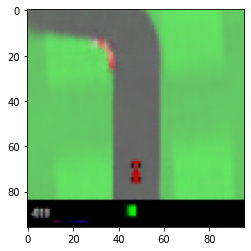

In [ ]:
im_g  = image_batch_recon[5].to("cpu").detach().permute(1,2,0).numpy() 
plt.imshow(im_g)

#display.clear_output(wait=True)
#display.display(plt.gcf())

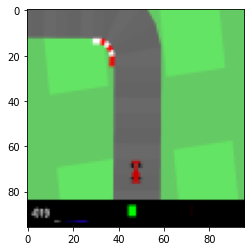

In [ ]:
im_g  = frames[5].to("cpu").detach().permute(1,2,0).numpy() 
plt.imshow(im_g)

## Loading trained VAE

In [ ]:
#torch.save(VAE.state_dict(), '/content/drive/MyDrive/Deep_proj/VAE_weights2.pth')

In [ ]:
VAE =VariationalAutoencoder(32, 64) # we do not specify pretrained=True, i.e. do not load default weights
if device.type == 'cpu':
  VAE.load_state_dict(torch.load('/content/drive/MyDrive/Deep_proj/VAE_weights2.pth', map_location=torch.device('cpu')))  
else:
  VAE.load_state_dict(torch.load('/content/drive/MyDrive/Deep_proj/VAE_weights2.pth'))
VAE.to(device)
VAE.eval()

VariationalAutoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (fc_mu): Linear(in_features=4608, out_features=64, bias=True)
    (fc_logvar): Linear(in_features=4608, out_features=64, bias=True)
    (activation): ReLU()
  )
  (decoder): Decoder(
    (fc): Linear(in_features=64, out_features=4608, bias=True)
    (conv5): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): ConvTranspose2d(64, 32,

## Training the LSTM_MDN

### creating dataset for LSTM

In [ ]:
#utility function
conversion = ToTensor()

In [ ]:
observations = []
actions = []
dones = []
rewards = []
for _ in range(1024 * 10):
  action = env.action_space.sample()#policy(observation)  # User-defined policy function, in this case random
  observation, reward, done, info = env.step(action)
  observations.append(conversion(observation))  #save current frame/observation
  actions.append(torch.tensor(action))  #save the action for lstm
  rewards.append(torch.tensor(reward))  
  if done:
    print("DONE")
    observation, info = env.reset(return_info=True)
    dones.append(torch.tensor(0))
  else:
    dones.append(torch.tensor(1))
  

env.close()

#this time observations are ordered since we have to predict the next one in the sequence 
#actions = torch.stack(actions)  #convert list to torch tensors
frames = torch.stack(observations)
frames = frames.to(device)
with torch.no_grad():
  _, latent_mu, _ = VAE(frames)
  #latent_mu = VAE.latent_sample(latent_mu,latent_var)



DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE
DONE


In [ ]:
pair_latent = []
#the latent feature and next latent feature,reward, done are saved  in a list of tensors with lengths 130
#where the first 64 elements are the latent dim
#then there are 3 elements for the action
#the last 66 elements are latent dim + done + reward of next step
latent_mu = latent_mu.to("cpu")
for i in range(0,len(observations)-1):
  pair_latent.append( torch.cat( (torch.cat((latent_mu[i],actions[i])), torch.cat((latent_mu[i+1],torch.stack([dones[i+1], rewards[i+1]])) ) )) )

In [ ]:
#random permutation of the list 
random.shuffle(pair_latent)
torch_pair = torch.stack(pair_latent)
torch_pair = torch_pair.to(device)

We now have gathered a dataset to train the LSTM

### Training LSTM

In [ ]:
learning_rate = 0.001
#utility function

In [ ]:
lstm = LSTM_MDN(64+3,256) #input size 64 latent code + action space which is 3, #256 hidden dim
#lstm = LSTM_MDN_v2(64+3,256, components=6)  #more stable but don't know if works with batches
#the output size of the the model is batch x 66
lstm.to(device)
optimizer = torch.optim.Adam(params=lstm.parameters(), lr=learning_rate, weight_decay=1e-5)

lstm.train()

LSTM_MDN(
  (lstm): LSTM(67, 256, batch_first=True)
  (mdn): MDN(
    (pi): Sequential(
      (0): Linear(in_features=256, out_features=6, bias=True)
      (1): Softmax(dim=1)
    )
    (sigma): Linear(in_features=256, out_features=396, bias=True)
    (mu): Linear(in_features=256, out_features=396, bias=True)
  )
)

In [ ]:
#separe from computational graph
latent_mu = latent_mu.detach()
latent_mu.requires_grad=False
full = True #full loss, also calculates loss of done and reward
gamma = 1
loss_BCE = nn.BCELoss()
alpha = 1
loss_l2 = nn.MSELoss()
beta = 1
latent_size = 64

#how many element in the batch each iteration, if too high nll may break and go to infinity (fixed)
batch_size = 512
epochs = 10

for ep in range(epochs):
  for i in range( 0, torch_pair.shape[0] - batch_size, batch_size):
    #the values are all concatenated in one vector
    #extract in dim=1, starting from element 0 to element 64
    #those encode the latent features
    minibatch = torch_pair[i: i+batch_size]
    latent_features = torch.narrow(minibatch, 1, 0, latent_size)
    #then the next 3 element encode the action
    action = torch.narrow(minibatch, 1, 64, 3)
    target_latent_space = torch.narrow(minibatch, 1, latent_size+3, latent_size)
    target_done = torch.narrow(minibatch, 1, latent_size*2+3, 1)
    target_reward = torch.narrow(minibatch, 1, latent_size*2+3 + 1, 1)

    #MODEL V1 TRAIN
    pi, sigma, mu = lstm(torch.cat((latent_features,action), dim=1))
    #extracting sigma and mu from prediction 
    simple_sigma = torch.narrow(sigma, 2,0,64)
    simple_mu = torch.narrow(mu, 2,0,64)
    loss = mdn_loss(pi, simple_sigma, simple_mu, target_latent_space)
    #MODEL V2 TRAIN
    #pi, normal = lstm(torch.cat((latent_mu[i].unsqueeze(0),acts), dim=1))
    #loss = mdn_loss_no_forward(pi, normal, latent_mu[i+1].unsqueeze(0))
    print("epoch: ",ep," NLL loss: ",loss.item())
    if full:
        #extract last 2 values
        mu_split = torch.narrow(mu, 2,-2,2)
        sigma_split = torch.narrow(sigma, 2,-2,2)
        #done is the first of the 2 values extracted
        mu_d = torch.narrow(mu, 2,0,1)
        sigma_d = torch.narrow(sigma, 2,0,1)
        #reward is the second and last values of tensor      
        mu_r = torch.narrow(mu, 2,1,1)
        sigma_r = torch.narrow(sigma, 2,1,1)
        prob_d_mix = F.softmax( torch.sum(mu_d, dim=1) ) #it must be a probability
        prob_r_mix = torch.sum(mu_r, dim=1)

        #TODO, now i need done value, and rewards value
        l_bce = loss_BCE(prob_d_mix,target_done)
        l_l2 = loss_l2(prob_r_mix,target_reward)
        #BCE loss with done flag
        #L2 loss with reward
        print("BCE loss :",l_bce.item())
        print("L2 loss :",l_l2.item())
        loss = loss * gamma + l_bce *alpha + l_l2 *beta
        print("final loss", loss.item(), "\n")
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    

epoch:  0  NLL loss:  32283.27734375
BCE loss : 0.1953125
L2 loss : 0.16177892684936523
final loss 32283.634765625 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch:  0  NLL loss:  31964.6171875
BCE loss : 0.0
L2 loss : 0.18159259855747223
final loss 31964.798828125 

epoch:  0  NLL loss:  31483.50390625
BCE loss : 0.0
L2 loss : 0.1591184139251709
final loss 31483.662109375 

epoch:  0  NLL loss:  31014.4453125
BCE loss : 0.1953125
L2 loss : 0.1445508450269699
final loss 31014.78515625 

epoch:  0  NLL loss:  30331.580078125
BCE loss : 0.390625
L2 loss : 0.3148193061351776
final loss 30332.28515625 

epoch:  0  NLL loss:  29118.73046875
BCE loss : 0.0
L2 loss : 0.3151472806930542
final loss 29119.044921875 

epoch:  0  NLL loss:  27124.984375
BCE loss : 0.0
L2 loss : 0.2682114243507385
final loss 27125.251953125 

epoch:  0  NLL loss:  22454.42578125
BCE loss : 0.0
L2 loss : 0.6285865306854248
final loss 22455.0546875 

epoch:  0  NLL loss:  13431.9189453125
BCE loss : 0.1953125
L2 loss : 0.9786079525947571
final loss 13433.0927734375 

epoch:  0  NLL loss:  9138.44921875
BCE loss : 0.0
L2 loss : 1.572493553161621
final loss 9140.021484375 


In [ ]:
latent_mu[1]

tensor([ 2.2521e-02,  8.4111e-03, -5.5026e-02, -2.9435e-01, -7.4661e-01,
        -8.3833e-02,  1.4859e-04, -3.2230e-02,  7.1269e-02, -1.0571e-01,
        -1.2210e-01,  9.3125e-02,  6.8061e-03, -8.3278e-01,  3.9829e-01,
        -5.1499e-02,  1.9345e-01,  2.1339e-01, -1.5280e-01,  2.2747e-01,
        -1.7675e-01,  1.3598e-01, -1.4431e+00, -5.8933e-04, -2.3014e-02,
         4.9119e-01,  2.7795e-01,  2.4765e-01,  8.3784e-02,  3.0139e-01,
         3.6088e-01,  6.3035e-02,  6.2429e-01,  3.4894e-01, -4.9882e-02,
         1.1154e-01,  1.2039e-01, -1.4820e-01, -1.8259e-01, -2.1257e-01,
        -1.8826e+00,  4.2255e-02, -3.0897e-01,  1.1721e-01,  5.0699e-02,
         1.3343e+00, -5.2100e-02,  6.6085e-02, -1.3865e-01,  1.5846e-01,
        -1.0205e+00,  1.1603e-01,  4.5458e-01,  2.7382e-01, -1.4243e-01,
        -2.2704e-02, -1.3610e-01,  1.8281e-01, -3.2850e-01, -7.0952e-02,
         4.7397e-02,  9.2332e-02,  1.9441e-01, -8.5124e-02])

In [ ]:
mu[1]

## SAVE AND LOAD MDN-RNN MODEL

In [ ]:
#torch.save(lstm.state_dict(), '/content/drive/MyDrive/Deep_proj/lstm_weights.pth')

In [ ]:
lstm = LSTM_MDN(64+3,256) # we do not specify pretrained=True, i.e. do not load default weights
if device.type == 'cpu':
  lstm.load_state_dict(torch.load('/content/drive/MyDrive/Deep_proj/lstm_weights.pth', map_location=torch.device('cpu')))  
else:
  lstm.load_state_dict(torch.load('/content/drive/MyDrive/Deep_proj/lstm_weights.pth'))
lstm.to(device)
lstm.eval()

LSTM_MDN(
  (lstm): LSTM(67, 256, batch_first=True)
  (mdn): MDN(
    (pi): Sequential(
      (0): Linear(in_features=256, out_features=6, bias=True)
      (1): Softmax(dim=1)
    )
    (sigma): Linear(in_features=256, out_features=396, bias=True)
    (mu): Linear(in_features=256, out_features=396, bias=True)
  )
)

# Car racing Controller

In [ ]:
from torch.multiprocessing import Process, Queue
import pickle

In [ ]:
#combine VAE and MDN-RNN
def compute_controller_input(observation, reward, done, action, only_VAE):
  #latent code is obtained with the VAE
  _,latent_mu,_ = VAE(conversion(observation).unsqueeze(0))
  if only_VAE:
    return latent_mu
  torch_action = torch.tensor(action).unsqueeze(0)
  #MDN-RNN computes the prediction for the next latent code with input the latent and past action
  pi, sigma, mu = lstm(torch.cat((latent_mu,torch_action), dim=1))
  prediction = sample_V1(pi,sigma,mu) #generate the prediction for the next latent
  #input for controller is current latent and predicted next latent
  input_controller = torch.cat( (latent_mu,prediction) , dim = 1)
  return input_controller

In [ ]:
def single_lap_reward(controller_weights, env, r_q = None, pid =0, only_VAE=False):
  #print("ciao sono processo n", pid)
  #TODO assicurarsi non usi variabili globali
  time = 0
  with torch.no_grad():    
    cumulative_reward = 0
    if only_VAE:
      controller = Controller(64,0,3)
      temp = torch.tensor(controller_weights, dtype=torch.float32).reshape(3,64)
    else:
      controller = Controller(64,66,3)
      temp = torch.tensor(controller_weights, dtype=torch.float32).reshape(3,130)
    controller.fc.weight = torch.nn.Parameter(temp.clone().detach(), requires_grad=False)
    #I use this flag because sometimes there is a random positive reward, but the lap is not completed
    #so it doesn't make much sense since the reward is only when a lap is DONE
    not_completed = True #set to true to impose full lap
    do = True #there is no do while in python
    done = False
    reward = 0
    observation, info = env.reset(return_info=True, seed = 42)  #TODO REMEMBER THE SEED IS FIXED !
    action = env.action_space.sample() #only the first action is random, to start the models
    #the rewards are assigned only when a lap is finished, so it must complete a lap 
    #positive reward is acquired only at the end of the lap
    #it is depends on the number of tiles visited and tipe required to complete the lap      
    while (reward <= 0 or do or not_completed):
      time+=1
      #print("time", time)
      do = False  #implements do while
      input_contr = compute_controller_input(observation, reward, done, action, only_VAE)

      action = controller(input_contr) #using generated weights to compute the best action
      #action = torch.tanh(action) #cap the values even if onlye the first action is between -1:1 the other 2 are in range 0:1
      action = action.squeeze(0)

      observation, reward, done, info = env.step(action.numpy())
      cumulative_reward += reward
      
      if done: 
        #print("DONE process: ", pid)
        not_completed = False
        observation, info = env.reset(return_info=True)
    #cumulative_reward = reward #take only last reward
    print("cumulative reward : ",cumulative_reward, "final reward : ", reward)
    if r_q != None:
      #print("salvato su Q pid:", pid, " rew ", cumulative_reward * -1)
      r_q.put((pid, cumulative_reward * -1))
    return cumulative_reward * -1


In [ ]:
controller = Controller(64,66,3) #latent space, MDN output, action size
params_count = controller.fc.weight.shape[0] * controller.fc.weight.shape[1]

In [ ]:
load_controller = True

In [ ]:
filename = "/content/drive/MyDrive/Deep_proj/controller"

In [ ]:
#simple monocore training
generations = 100
pop_size = 4
es = cma.CMAEvolutionStrategy(params_count * [0], 0.10, {'popsize': pop_size})
if load_controller:
  s = open(filename+"mono_core", 'rb').read()
  es = pickle.loads(s)
  print("caricato da file con successo")

with torch.no_grad():
  for gen in range(generations): 

    rewards_pop = []
    count = 0
    w = es.ask() #generates weights for all population
    #each population memeber performs a lap and obtain its reward
    for pop in w: 
      r = single_lap_reward(pop, env)
      rewards_pop.append(r)
      
    print("negative reward list", rewards_pop)
    print("")
    es.tell(w,rewards_pop)  #optimize
    es.disp() 
    print("")
    if gen % 3 == 0 :
      save_str = es.pickle_dumps()
      open(filename+"mono_core", 'wb').write(save_str)

  env.close()


(2_w,4mirr1)-aCMA-ES (mu_w=1.5,w_1=80%) in dimension 390 (seed=760948, Sat Aug 27 14:54:45 2022)
caricato da file con successo


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


cumulative reward :  8.930875282395911 final reward :  6.457377049180328
cumulative reward :  19.53158199617674 final reward :  6.457377049180328
cumulative reward :  19.531581996175767 final reward :  6.457377049180328
cumulative reward :  8.930875282396132 final reward :  6.457377049180328
negative reward list [-8.930875282395911, -19.53158199617674, -19.531581996175767, -8.930875282396132]

  101    404 -1.953158199617674e+01 1.1e+00 6.48e-02  6e-02  6e-02 321:23.5

cumulative reward :  15.99801309158245 final reward :  6.457377049180328
cumulative reward :  23.06515090076943 final reward :  6.457377049180328
cumulative reward :  12.46444418698975 final reward :  6.457377049180328
cumulative reward :  -51.13979609569658 final reward :  6.457377049180328
negative reward list [-15.99801309158245, -23.06515090076943, -12.46444418698975, 51.13979609569658]

  102    408 -2.306515090076943e+01 1.1e+00 6.47e-02  6e-02  6e-02 324:31.9

cumulative reward :  -19.337675954353237 final reward 

KeyboardInterrupt: ignored

In [ ]:
#multiprocessing training
generations = 100
pop_size = 4
#optimizer = CMA(mean=np.zeros(params_count), sigma=0.1)
es = cma.CMAEvolutionStrategy(params_count * [0], 0.1, {'popsize': pop_size})
if load_controller:
  s = open(filename, 'rb').read()
  es = pickle.loads(s)


env2 = gym.make("CarRacing-v2")
env3 = gym.make("CarRacing-v2")
env4 = gym.make("CarRacing-v2")
env_list = [env, env2, env3, env4]
reward_queue = Queue()

with torch.no_grad():

  for gen in range(generations): 

    rewards_pop = [0] * pop_size
    count = 0
    proc_list = []
    w = es.ask() #generates weights for all population
    for pop in w: 
      p = Process(target=single_lap_reward, args=(pop, env_list[count], reward_queue, count))      
      p.start()
      proc_list.append(p)
      count += 1
    for proc in proc_list:
      proc.join()
    while not reward_queue.empty():
      indx, r = reward_queue.get()
      rewards_pop[indx] = r

    print("reward list", rewards_pop)
    print("")
    es.tell(w,rewards_pop)  
    es.disp()
    print("")
    if gen % 5 == 0 :
      save_str = es.pickle_dumps()
      open(filename, 'wb').write(save_str)

  env.close()


In [ ]:
controller = Controller(64,0,3) #latent space, MDN output, action size
params_count = controller.fc.weight.shape[0] * controller.fc.weight.shape[1]

In [ ]:
#only train using VAE
generations = 100
pop_size = 4
es = cma.CMAEvolutionStrategy(params_count * [0], 0.10, {'popsize': pop_size})
if load_controller:
  s = open(filename+"only_VAE", 'rb').read()
  es = pickle.loads(s)
  print("caricato da file con successo")

with torch.no_grad():
  for gen in range(generations): 

    rewards_pop = []
    count = 0
    w = es.ask() #generates weights for all population
    #each population memeber performs a lap and obtain its reward
    for pop in w: 
      r = single_lap_reward(pop, env, only_VAE=True)
      rewards_pop.append(r)
      
    print("negative reward list", rewards_pop)
    print("")
    es.tell(w,rewards_pop)  #optimize
    es.disp() 
    print("")
    if gen % 3 == 0 :
      save_str = es.pickle_dumps()
      open(filename+"only_VAE", 'wb').write(save_str)

  env.close()


(2_w,4mirr1)-aCMA-ES (mu_w=1.5,w_1=80%) in dimension 192 (seed=834266, Sun Aug 28 08:11:38 2022)
caricato da file con successo
cumulative reward :  37.19942651914765 final reward :  6.457377049180328
cumulative reward :  30.132288709959802 final reward :  6.457377049180328
cumulative reward :  26.59871980536596 final reward :  6.457377049180328
cumulative reward :  33.66585761455374 final reward :  6.457377049180328
negative reward list [-37.19942651914765, -30.132288709959802, -26.59871980536596, -33.66585761455374]

   17     68 -3.719942651914765e+01 1.0e+00 8.02e-02  8e-02  8e-02 54:58.8

cumulative reward :  33.665857614553765 final reward :  6.457377049180328
cumulative reward :  37.19942651914765 final reward :  6.457377049180328
cumulative reward :  37.19942651914762 final reward :  6.457377049180328
cumulative reward :  26.598719805365974 final reward :  6.457377049180328
negative reward list [-33.665857614553765, -37.19942651914765, -37.19942651914762, -26.598719805365974]

 

In [ ]:
action = env.action_space.sample()
observation, reward, done, info = env.step(action)

In [ ]:
image_batch_recon, latent_mu, latent_logvar = VAE(conversion(observation).unsqueeze(0)) 

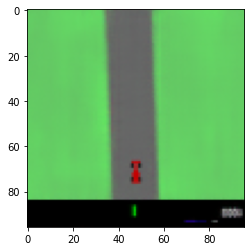

In [ ]:
im_g  = image_batch_recon[0].to("cpu").detach().permute(1,2,0).numpy() 
plt.imshow(im_g)

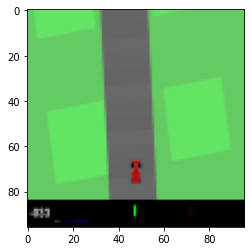

In [ ]:
im_g  = observation 
plt.imshow(im_g)

In [ ]:
len(es.ask())

4

# Procgen World Model

In [ ]:
!pip install procgen > /dev/null 2>&1

In [ ]:
import gym
env = gym.make('procgen:procgen-coinrun-v0',distribution_mode="hard", use_backgrounds=True)#,distribution_mode="easy")   #default hard
env_car = gym.make("CarRacing-v2")
obs = env.reset()
obs2 = env_car.reset()

/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:175: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  "Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator."
/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:191: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  "Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting."
/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:196: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed a

In [ ]:
#simulating times
import time
start = time.time()
cnt = 0
while cnt < 10000:
    cnt +=1
    obs, rew, done, info = env.step(env.action_space.sample())
    #env.render()
    if done:
        env.reset()
stop = strat = time.time()
print("proc env time :",stop-start)
start = time.time()
cnt = 0
while cnt < 10000:
    cnt +=1
    obs, rew, done, info = env_car.step(env_car.action_space.sample())
    if done:
        env_car.reset()
    #env.render()
stop = strat = time.time()
print("car env time :",stop-start)

proc env time : 0.8103864192962646
proc env time : 121.51142978668213


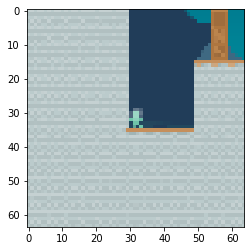

In [ ]:
obs_tensor = conversion(obs)
im_g  = obs_tensor.to("cpu").detach().permute(1,2,0).numpy() 
plt.imshow(im_g)

## train VAE

In [ ]:
learning_rate = 0.001
VAE = VariationalAutoencoder(64,32, 4096) #32 hidden dim and 32 latent size are from world model article
VAE.to(device)
optimizer_VAE = torch.optim.Adam(params=VAE.parameters(), lr=learning_rate, weight_decay=1e-5)

VAE.train()
print("")

this is just a small bootstrap to start the VAE, but will be countinuously updated since the environment is procedural

In [ ]:
!pip install kornia

In [ ]:
import kornia.filters as K

In [ ]:
transforms = torch.nn.Sequential(    
    RandomHorizontalFlip(p=0.50),
    #RandomRotation(degrees=(-45,45))
    #T.Grayscale(num_output_channels=3)
)

In [ ]:
#L_loss = nn.L1Loss()
L_loss = nn.MSELoss(size_average=False)
obs = env.reset()
obs_list=[]
ep = 0
skip = 0
batch_size = 256
while(ep < 25000):  
    obs, rew, done, info = env.step(env.action_space.sample())
    if skip % 50 == 0:
      obs_list.append(conversion(obs))
    skip+=1
    if done:
        env.reset()
        ep += 1
        if ep %100 == 0:
         print("simulation : ",ep)
    if len(obs_list) == batch_size:
        random.shuffle(obs_list)
        #create batch        
        torch_obs = torch.stack(obs_list)
        torch_obs = torch_obs.to(device)
        torch_obs = transforms(torch_obs) #increase robustness
        #train
        #image_batch_recon, latent_mu, latent_logvar = VAE(torch_obs)
        #loss = vae_loss(image_batch_recon, torch_obs, latent_mu, latent_logvar)

        edges = K.sobel(torch_obs)   *2     
        #---edges are added/subracted from original images
        #clamped_edges = torch.clamp(torch_obs/1.3 + edges, min = 0.0, max = 1.0)
        #loss_edges = L_loss(image_batch_recon, clamped_edges)
        #---only computed on edges
        #loss_edges = L_loss(image_batch_recon, edges)
        #---using edges as target and/or input
        clamped_edges = torch.clamp(edges, min = 0.0, max = 1.0)
        image_batch_recon, latent_mu, latent_logvar = VAE(clamped_edges)        
        loss = vae_loss(image_batch_recon, clamped_edges, latent_mu, latent_logvar)
        loss_fin = loss #+  loss_edges *0.8

        print("loss VAE: ", loss.item()/ batch_size)#, "loss edges: ", loss_edges.item() /batch_size)
        optimizer_VAE.zero_grad()
        loss_fin.backward()
        optimizer_VAE.step()
        obs_list=[]

loss VAE:  2591.49267578125
loss VAE:  2437.5654296875
loss VAE:  1154.0260009765625
loss VAE:  839.5003662109375
loss VAE:  389.84405517578125
simulation :  100
loss VAE:  208.56289672851562
loss VAE:  265.6042175292969
loss VAE:  199.6029052734375
loss VAE:  227.24951171875
loss VAE:  237.5644073486328
simulation :  200
loss VAE:  221.32037353515625
loss VAE:  199.0595245361328
loss VAE:  187.48892211914062
loss VAE:  228.24038696289062
loss VAE:  221.36227416992188
simulation :  300
loss VAE:  208.63522338867188
loss VAE:  195.5689697265625
loss VAE:  239.14739990234375
loss VAE:  192.85989379882812
loss VAE:  171.67425537109375
simulation :  400
loss VAE:  190.59637451171875
loss VAE:  182.1974639892578
loss VAE:  159.60755920410156
loss VAE:  207.0596466064453
loss VAE:  182.32598876953125
simulation :  500
loss VAE:  172.124267578125
loss VAE:  234.6572723388672
loss VAE:  196.52474975585938
loss VAE:  208.55642700195312
loss VAE:  186.71890258789062
simulation :  600
loss VAE:  

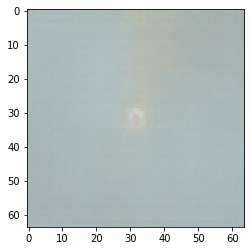

In [ ]:
idx = 100
im_g  = image_batch_recon[idx].to("cpu").detach().permute(1,2,0).numpy() 
plt.imshow(im_g)

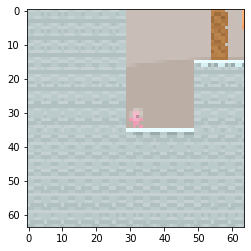

In [ ]:
im_g  = torch_obs[idx].to("cpu").detach().permute(1,2,0).numpy() 
plt.imshow(im_g)

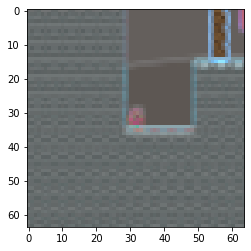

In [ ]:
edges = K.sobel(torch_obs) *2
#edges = K.laplacian(torch_obs, kernel_size=3) *2
#edges = K.canny(torch_obs, low_threshold=0.01, high_threshold=0.5)[1]
#edges = torch.cat((edges,edges,edges), dim=1)
clampled = torch.clamp(torch_obs/2 + edges, min = 0.0, max = 1.0)
im_g_f  = clampled[idx].to("cpu").detach().permute(1,2,0).numpy() 
#im_g_f = im_g - im_g_f *2
plt.imshow(im_g_f)

In [ ]:
torch.save(VAE.state_dict(), '/content/drive/MyDrive/Deep_proj/VAE_proc1'+"manual"+'.pth')

## Functions Controller

In [ ]:
def single_lap_reward(controller_weights, env, r_q = None, pid =0, only_VAE=False):
  #print("ciao sono processo n", pid)
  #TODO assicurarsi non usi variabili globali
  time = 0
  with torch.no_grad():
    
    cumulative_reward = 0
    if only_VAE:
      controller = Controller(32,0,15)
      temp = torch.tensor(controller_weights, dtype=torch.float32).reshape(15,32)
    else:
      controller = Controller(32,34,15)
      temp = torch.tensor(controller_weights, dtype=torch.float32).reshape(15,66)
    controller.fc.weight = torch.nn.Parameter(temp.clone().detach(), requires_grad=False)
    #I use this flag because sometimes there is a random positive reward, but the lap is not completed
    #so it doesn't make much sense since the reward is only when a lap is DONE
    not_completed = True #set to true to impose full lap
    do = True #there is no do while in python
    done = False
    reward = 0
    observation = env.reset()  
    action = env.action_space.sample() #only the first action is random, to start the models
    #the rewards are assigned only when a lap is finished, so it must complete a lap 
    #positive reward is acquired only at the end of the lap
    #it is depends on the number of tiles visited and tipe required to complete the lap      
    while (do or not_completed):    #reward <= 0 or condizione rimossa, sperando questo env sia stabile
      time+=1
      #print("time", time)
      do = False  #implements do while
      input_contr = compute_controller_input(observation, reward, done, action, only_VAE)

      action = controller(input_contr) 
      action = torch.argmax(action)

      observation, reward, done, info = env.step(action.numpy())
      cumulative_reward += reward
      
      if done: 
        #print("DONE process: ", pid)
        not_completed = False
        observation = env.reset()
    #cumulative_reward = reward #take only last reward
    print("cumulative reward : ",cumulative_reward, "final reward : ", reward)
    if r_q != None:
      #print("salvato su Q pid:", pid, " rew ", cumulative_reward * -1)
      r_q.put((pid, cumulative_reward * -1))
    return cumulative_reward * -1


In [ ]:
#combine VAE and MDN-RNN
def compute_controller_input(observation, reward, done, action, only_VAE):
  #latent code is obtained with the VAE
  observation = observation.to(device)
  _,latent_mu,_ = VAE(observation.unsqueeze(0))
  if only_VAE:
    return latent_mu.to('cpu')
  torch_action = torch.tensor(action).unsqueeze(0)
  #MDN-RNN computes the prediction for the next latent code with input the latent and past action
  pi, sigma, mu = lstm(torch.cat((latent_mu,torch_action), dim=1))
  prediction = sample_V1(pi,sigma,mu) #generate the prediction for the next latent
  #input for controller is current latent and predicted next latent
  input_controller = torch.cat( (latent_mu,prediction) , dim = 1)
  return input_controller

# continuous update of models_only_VAE

In [ ]:
controller = Controller(32, 0, 15)  #input size 32+0, output size 15 (action space)
params_count = controller.fc.weight.shape[0] * controller.fc.weight.shape[1]

In [ ]:
filename = "/content/drive/MyDrive/Deep_proj/Proc_contr1"
load_controller = False


In [ ]:
#only train using VAE
generations = 150
update_VAE = False
#pop_size = 4 #let the optimizer decide
optimizer_VAE = torch.optim.Adam(params=VAE.parameters(), lr=learning_rate, weight_decay=1e-5)
es = cma.CMAEvolutionStrategy(params_count * [0], 0.10)# {'popsize': pop_size}
if load_controller:
  s = open(filename+"only_VAE", 'rb').read()
  es = pickle.loads(s)
  print("caricato da file con successo")

VAE_batch = []
for gen in range(generations): 

  rewards_pop = []
  time_list = []
  count = 0
  w = es.ask() #generates weights for all population
  #each population memeber performs a lap and obtain its reward
  for pop in w: 
    #start a simulation of an proceduraly generated environment

    time = 0
    with torch.no_grad():
      #PREPARING THE SIMULATION    
      cumulative_reward = 0
      temp = torch.tensor(pop, dtype=torch.float32).reshape(15,32)
      controller.fc.weight = torch.nn.Parameter(temp.clone().detach(), requires_grad=False)
      #I use this flag because sometimes there is a random positive reward, but the lap is not completed
      #so it doesn't make much sense since the reward is only when a lap is DONE
      not_completed = True #set to true to impose full lap
      do = True #there is no do while in python
      done = False
      reward = 0
      observation = env.reset()  
      action = env.action_space.sample() #only the first action is random, to start the models
      
      #MAIN LOOP, RUNNING THE SIMULATION      
      while (do or not_completed):    #reward <= 0 or condizione rimossa, sperando questo env sia stabile
        time+=1
        #print("time", time)
        do = False  #implements do while
        observation = conversion(observation)
        input_contr = compute_controller_input(observation, reward, done, action, only_VAE=True)

        action = controller(input_contr) 
        action = torch.argmax(action)

        #save some random observation to update VAE
        if time % 25 == 0 :
          VAE_batch.append(observation)

        #step forward
        observation, reward, done, info = env.step(action.numpy())
        cumulative_reward += reward
        
        if done: 
          #print("DONE")
          not_completed = False
          observation = env.reset()
      #cumulative_reward = reward #take only last reward
      #print("cumulative reward : ",cumulative_reward)
    


    r = -cumulative_reward
    rewards_pop.append(r)
    time_list.append(time)
    
  print("negative reward list", rewards_pop)
  print("time list :",time_list)
  print("")
  es.tell(w, rewards_pop)  #optimize
  es.disp() 
  print("")
  if gen % 10 == 0 :
    save_str = es.pickle_dumps()
    open(filename+"only_VAE", 'wb').write(save_str)
    print("checkpoit raggiunto")

  #update VAE at the end of generation
  if update_VAE:
    #create batch
    torch_obs = torch.stack(VAE_batch)
    torch_obs = torch_obs.to(device)
    #train
    image_batch_recon, latent_mu, latent_logvar = VAE(torch_obs)
    loss = vae_loss(image_batch_recon, torch_obs, latent_mu, latent_logvar) 
    print("loss VAE: ", loss.item()/100)
    optimizer_VAE.zero_grad()
    loss.backward()
    optimizer_VAE.step()
  VAE_batch=[]

  if gen % 65 == 0 and update_VAE: #around every 25 min
    torch.save(VAE.state_dict(), '/content/drive/MyDrive/Deep_proj/VAE_proc1'+str(gen)+'.pth')

env.close()


(11_w,22)-aCMA-ES (mu_w=6.5,w_1=26%) in dimension 480 (seed=995968, Tue Aug 30 11:49:59 2022)
negative reward list [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]
time list : [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 219, 1000, 1000, 1000, 1000]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     22 -0.000000000000000e+00 1.0e+00 9.86e-02  1e-01  1e-01 0:43.1

checkpoit raggiunto
negative reward list [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]
time list : [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]

    2     44 -0.000000000000000e+00 1.0e+00 9.74e-02  1e-01  1e-01 1:26.2

negative reward list [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -

KeyboardInterrupt: ignored

In [ ]:
#torch.save(VAE.state_dict(), '/content/drive/MyDrive/Deep_proj/VAE_proc0'+"manual"+'.pth')

In [ ]:
#save_str = es.pickle_dumps()
#open(filename+"only_VAE", 'wb').write(save_str)
print("checkpoit raggiunto")

checkpoit raggiunto


In [ ]:
x = torch.rand((1,15))
y = F.softmax(x, dim = 1)
z = torch.argmax(y)
print(x,y,z)

tensor([[0.9675, 0.6152, 0.0116, 0.3584, 0.8898, 0.0871, 0.7516, 0.5624, 0.1411,
         0.7155, 0.7313, 0.6891, 0.6048, 0.4607, 0.6243]]) tensor([[0.0979, 0.0688, 0.0376, 0.0532, 0.0906, 0.0406, 0.0789, 0.0653, 0.0428,
         0.0761, 0.0773, 0.0741, 0.0681, 0.0590, 0.0695]]) tensor(0)


# Train MDN-RNN and full model

In [ ]:
lstm = LSTM_MDN(input_size = 32+15,hidden_size = 256, latent_dim=32)
#lstm.to(device)
lstm.to("cpu")  #it is instant, just lstm cell and a Linear
optimizer_lstm = torch.optim.Adam(params=lstm.parameters(), lr=learning_rate, weight_decay=1e-5)
lstm.train()
print("")

In [ ]:
gamma = 1
loss_BCE = nn.BCELoss()
alpha = 1
loss_l2 = nn.MSELoss()
beta = 1

def update_lstm(lstm, opt_lstm, latent_code, next_latent, act, next_done, next_r):
  #latent_code = latent_code.detach()
  #latent_code.requires_grad=False
  #next_latent = next_latent.detach()
  #next_latent.requires_grad=False

  latent_torch = torch.stack(latent_code).squeeze(1)
  next_latent_torch = torch.stack(next_latent).squeeze(1)
  target_done = torch.stack(next_done)
  target_reward = torch.stack(next_r)
  action_torch = torch.stack(act).squeeze(1)
  lstm_input = torch.cat((latent_torch, action_torch), dim=1)

  pi, sigma, mu = lstm(lstm_input)
  #extracting sigma and mu from prediction 
  simple_sigma = torch.narrow(sigma, 2,0,32)
  simple_mu = torch.narrow(mu, 2,0,32)
  loss = mdn_loss(pi, simple_sigma, simple_mu, next_latent_torch)

  #extracting done and reward from sigma and mu
  #extract last 2 values
  mu_split = torch.narrow(mu, 2,-2,2)
  sigma_split = torch.narrow(sigma, 2,-2,2)
  #done is the first of the 2 values extracted
  mu_d = torch.narrow(mu, 2,0,1)
  sigma_d = torch.narrow(sigma, 2,0,1)
  #reward is the second and last values of tensor      
  mu_r = torch.narrow(mu, 2,1,1)
  sigma_r = torch.narrow(sigma, 2,1,1)
  prob_d_mix = F.softmax( torch.sum(mu_d, dim=1) ) #it must be a probability
  prob_r_mix = torch.sum(mu_r, dim=1) #summing the gaussians

  #print(prob_d_mix.dtype, target_done.dtype)
  l_bce = loss_BCE(prob_d_mix.squeeze(1),target_done)
  l_l2 = loss_l2(prob_r_mix.squeeze(1),target_reward)
  #BCE loss with done flag
  #L2 loss with reward
  #print("BCE loss :",l_bce.item())
  #print("L2 loss :",l_l2.item())
  loss = loss * gamma + l_bce *alpha + l_l2 *beta
  print("final loss", loss.item(), "\n")
    
  opt_lstm.zero_grad()
  loss.backward()
  opt_lstm.step()



In [ ]:
controller = Controller(32, 34, 15)  #input size 32+34, output size 15 (action space)
params_count = controller.fc.weight.shape[0] * controller.fc.weight.shape[1]

In [ ]:
filename = "/content/drive/MyDrive/Deep_proj/Proc_contr_full"
load_controller = False

In [ ]:
#combine everything together
#important flags
update_VAE = False
update_MDNRNN = False

generations = 150
timeout = 799
#pop_size = 4 #let the optimizer decide
optimizer_VAE = torch.optim.Adam(params=VAE.parameters(), lr=learning_rate, weight_decay=1e-5)
optimizer_lstm = torch.optim.Adam(params=lstm.parameters(), lr=learning_rate, weight_decay=1e-5)
es = cma.CMAEvolutionStrategy(params_count * [0], 0.15)# {'popsize': pop_size}

if load_controller:
  s = open(filename, 'rb').read()
  es = pickle.loads(s)
  print("caricato da file con successo")

VAE_batch = []

current_latent = []
next_latent = []
current_action = []
next_done = []
next_r = []
target_MDNRNN = False
observation = env.reset() 
for gen in range(generations): 
  rewards_pop = []
  time_list = []
  count = 0
  w = es.ask() #generates weights for all population
  for pop in w: 
    #start a simulation of an proceduraly generated environment

    time = 0
    with torch.no_grad():
      #PREPARING THE SIMULATION    
      cumulative_reward = 0
      temp = torch.tensor(pop, dtype=torch.float32).reshape(15,66)
      controller.fc.weight = torch.nn.Parameter(temp.clone().detach(), requires_grad=False)

      not_completed = True #set to true to impose full lap
      do = True #set to True to make a do-while
      done = False
      reward = 0
       
      action = env.action_space.sample() #only the first action is random, to start the models
      
      #MAIN LOOP, RUNNING THE SIMULATION      
      while (do or not_completed):    #reward <= 0 or condizione rimossa, sperando questo env sia stabile
        time+=1
        #print(time)
        action_list = [0]*15
        do = False  #implements do while
        observation = conversion(observation)
        
        #PREPARING DATA
        observation = observation.to(device)
        _,latent_mu,_ = VAE(observation.unsqueeze(0)) #VAE forward
        latent_mu = latent_mu.to('cpu') 

        if update_MDNRNN: #collect data for MDNRNN
          if target_MDNRNN: #serching for target
            next_latent.append(latent_mu)
          else: #serching for input
            current_latent.append(latent_mu)

        #one hot encoding of action and conversion to tensor
        action_list[action] = 1 
        torch_action = torch.tensor(action_list).unsqueeze(0)

        if update_MDNRNN: #collect data for MDNRNN
          if not target_MDNRNN:   #need only current action
            current_action.append(torch_action)

        #MDN-RNN computes the prediction for the next latent code with input the latent and past action
        pi, sigma, mu = lstm(torch.cat((latent_mu,torch_action), dim=1))
        prediction = sample_V1(pi,sigma,mu) #generate the prediction for the next latent
        #input for controller is current latent and predicted next latent
        input_controller = torch.cat( (latent_mu,prediction) , dim = 1)

        action = controller(input_controller)  #forward controller
        action = torch.argmax(action) #argmax is the choosen action

        #save some random observation to update VAE
        if time % 15 == 0 and update_VAE:
          VAE_batch.append(observation)

        #step forward
        observation, reward, done, info = env.step(action.numpy())
        cumulative_reward += reward
        
        if  time > timeout:   
          pass   
          #done = True  #timeout doesn't work
        if done: 
          #print("DONE ", time)
          not_completed = False
          observation = env.reset()
      
        if update_MDNRNN: #collect data for MDNRNN
          if target_MDNRNN:   #constructing target
            if done:
              next_done.append(torch.tensor(0.0))
            else:
              next_done.append(torch.tensor(1.0))
            next_r.append(torch.tensor(reward))
            target_MDNRNN = False #now collect input
          else:
            target_MDNRNN = True        
    if update_MDNRNN and len(next_latent)>1:
      #check if loop endend before collecting target
      #print(len(current_latent), len(next_latent))
      if len(current_latent) > len(next_latent):
        current_latent = current_latent[:-1]
        current_action = current_action[:-1]
      update_lstm(lstm, optimizer_lstm,current_latent, next_latent, current_action, next_done, next_r)
    current_latent = []
    next_latent = []
    current_action = []
    next_done = []
    next_r = []
    target_MDNRNN = False

    #save reward and timestamp
    r = -cumulative_reward
    rewards_pop.append(r)
    time_list.append(time)
    
  print("negative reward list", rewards_pop)
  print("time list :",time_list)
  print("")
  es.tell(w, rewards_pop)  #optimize
  es.disp() 
  print("")
  if gen % 10 == 0 :
    save_str = es.pickle_dumps()
    open(filename, 'wb').write(save_str)
    print("checkpoit raggiunto")

  #update VAE at the end of generation
  if update_VAE:
    #create batch
    torch_obs = torch.stack(VAE_batch)
    torch_obs = torch_obs.to(device)
    #train
    image_batch_recon, latent_mu, latent_logvar = VAE(torch_obs)
    loss = vae_loss(image_batch_recon, torch_obs, latent_mu, latent_logvar) 
    print("loss VAE: ", loss.item())
    optimizer_VAE.zero_grad()
    loss.backward()
    optimizer_VAE.step()
  VAE_batch=[]

  if gen % 75 == 0 and update_VAE: #around every 25 min
    torch.save(VAE.state_dict(), '/content/drive/MyDrive/Deep_proj/VAE_proc0'+str(gen)+'.pth')




(12_w,24)-aCMA-ES (mu_w=7.0,w_1=24%) in dimension 990 (seed=753992, Sun Aug 28 14:34:35 2022)
negative reward list [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]
time list : [871, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 23, 1000, 1000, 1000, 1000, 1000, 1000, 1000]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     24 -0.000000000000000e+00 1.0e+00 1.49e-01  1e-01  1e-01 1:05.1

checkpoit raggiunto
negative reward list [-0.0, -0.0, -0.0, -10.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -10.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]
time list : [1000, 978, 1000, 54, 1000, 1000, 1000, 1000, 1000, 1000, 75, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]

    2     48 -1.000000000000000e+01 1.0e+00 1.48e-01  1e-01  1e-01 2:07.9

negative reward list [

In [ ]:
#torch.save(lstm.state_dict(), '/content/drive/MyDrive/Deep_proj/MDN_proc0'+'manual'+'.pth')
#save_str = es.pickle_dumps()
#open(filename, 'wb').write(save_str)

21177641

# Benchmark

## benchmark only VAE

In [ ]:
VAE = VariationalAutoencoder(32,32, 2048)  # we do not specify pretrained=True, i.e. do not load default weights
if device.type == 'cpu':
  VAE.load_state_dict(torch.load('/content/drive/MyDrive/Deep_proj/VAE_proc0'+"manual"+'.pth', map_location=torch.device('cpu')))  
else:
  VAE.load_state_dict(torch.load('/content/drive/MyDrive/Deep_proj/VAE_proc0'+"manual"+'.pth'))
VAE.to(device)
VAE.eval()

VariationalAutoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (fc_mu): Linear(in_features=2048, out_features=32, bias=True)
    (fc_logvar): Linear(in_features=2048, out_features=32, bias=True)
    (activation): ReLU()
  )
  (decoder): Decoder(
    (fc): Linear(in_features=32, out_features=2048, bias=True)
    (conv5): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): ConvTranspose2d(64, 32,

In [ ]:
filename = "/content/drive/MyDrive/Deep_proj/Proc_contr"
s = open(filename+"only_VAE", 'rb').read()
es = pickle.loads(s)
print("caricato da file con successo")

caricato da file con successo


In [ ]:
controller = Controller(32, 0, 15)
w = es.ask()

In [ ]:
for i in range(4):
  print("working with best parameters n:", i)
  temp = torch.tensor(w[i], dtype=torch.float32).reshape(15,32)
  controller.fc.weight = torch.nn.Parameter(temp.clone().detach(), requires_grad=False)
  total_rewards = []
  action = env.action_space.sample() #only the first action is random, to start the models
  observation = env.reset()
  reward = 0
  cumulative_rewards = 0
  for j in range(1000):
    if j % 100 == 0:
      print("it",j)
    #simulate 3k rounds        
    done = False
    while(not done):
      with torch.no_grad():
        observation = conversion(observation)
        input_contr = compute_controller_input(observation, reward, done, action, only_VAE=True)

        action = controller(input_contr) 
        action = torch.argmax(action)

        observation, reward, done, info = env.step(action.numpy())
        cumulative_rewards += reward
        if done: 
          #print("DONE")
          observation = env.reset()
  total_rewards.append(cumulative_rewards)
  #c'è solamente un reward di 10 in caso di successo quindi rewards / giri * 10 (un fattore 10 è già incluso)
  print("il controller :",i," ha completato il :", (cumulative_rewards/1000)*10, "%")

working with best parameters n: 0
it 0
it 100
it 200
it 300
it 400
it 500
it 600
it 700
it 800
it 900
il controller : 0  ha completato il : 43.099999999999994 %
working with best parameters n: 1
it 0
it 100
it 200
it 300
it 400
it 500
it 600
it 700
it 800
it 900
il controller : 1  ha completato il : 46.5 %
working with best parameters n: 2
it 0
it 100
it 200
it 300
it 400
it 500
it 600
it 700
it 800
it 900
il controller : 2  ha completato il : 49.6 %
working with best parameters n: 3
it 0
it 100
it 200
it 300
it 400
it 500
it 600
it 700
it 800
it 900
il controller : 3  ha completato il : 45.9 %


## Benchmark models combined

In [ ]:
VAE = VariationalAutoencoder(32,32, 2048)  # we do not specify pretrained=True, i.e. do not load default weights
if device.type == 'cpu':
  VAE.load_state_dict(torch.load('/content/drive/MyDrive/Deep_proj/VAE_proc0'+"manual"+'.pth', map_location=torch.device('cpu')))  
else:
  VAE.load_state_dict(torch.load('/content/drive/MyDrive/Deep_proj/VAE_proc0'+"manual"+'.pth'))
VAE.to(device)
VAE.eval()

In [ ]:
lstm = LSTM_MDN(input_size = 32+15,hidden_size = 256, latent_dim=32)
lstm.load_state_dict(torch.load('/content/drive/MyDrive/Deep_proj/MDN_proc0'+"manual"+'.pth', map_location=torch.device('cpu')))  
lstm.to("cpu")
lstm.eval()

LSTM_MDN(
  (lstm): LSTM(47, 256, batch_first=True)
  (mdn): MDN(
    (pi): Sequential(
      (0): Linear(in_features=256, out_features=6, bias=True)
      (1): Softmax(dim=1)
    )
    (sigma): Linear(in_features=256, out_features=204, bias=True)
    (mu): Linear(in_features=256, out_features=204, bias=True)
  )
)

In [ ]:
filename = "/content/drive/MyDrive/Deep_proj/Proc_contr_full"
s = open(filename, 'rb').read()
es = pickle.loads(s)
print("caricato da file con successo")

caricato da file con successo


In [ ]:
controller = Controller(32, 34, 15)
w = es.ask()

In [ ]:
for i in range(4):
  print("working with best parameters n:", i)
  temp = torch.tensor(w[i], dtype=torch.float32).reshape(15,66)
  controller.fc.weight = torch.nn.Parameter(temp.clone().detach(), requires_grad=False)
  total_rewards = []
  action = env.action_space.sample() #only the first action is random, to start the models
  observation = env.reset()
  reward = 0
  cumulative_rewards = 0
  for j in range(1000):
    if j % 100 == 0:
      print("it",j)
    #simulate 3k rounds        
    done = False
    while(not done):
      with torch.no_grad():
        observation = conversion(observation)
        
        observation = observation.to(device)
        _,latent_mu,_ = VAE(observation.unsqueeze(0)) #VAE forward
        latent_mu = latent_mu.to('cpu') 

        #one hot encoding of action and conversion to tensor
        action_list = [0]*15
        action_list[action] = 1 
        torch_action = torch.tensor(action_list).unsqueeze(0)

        pi, sigma, mu = lstm(torch.cat((latent_mu,torch_action), dim=1))
        prediction = sample_V1(pi,sigma,mu) #generate the prediction for the next latent
        #input for controller is current latent and predicted next latent
        input_controller = torch.cat( (latent_mu,prediction) , dim = 1)

        action = controller(input_controller) 
        action = torch.argmax(action)

        observation, reward, done, info = env.step(action.numpy())
        cumulative_rewards += reward
        if done: 
          #print("DONE")
          observation = env.reset()
  total_rewards.append(cumulative_rewards)
  #c'è solamente un reward di 10 in caso di successo quindi rewards / giri * 10 (un fattore 10 è già incluso)
  print("il controller :",i," ha completato il :", (cumulative_rewards/1000)*10, "%")

working with best parameters n: 0
it 0
it 100
it 200
it 300
it 400
it 500
it 600
it 700
it 800
it 900
il controller : 0  ha completato il : 60.099999999999994 %
working with best parameters n: 1
it 0
it 100
it 200
it 300
it 400
it 500
it 600
it 700
it 800
it 900
il controller : 1  ha completato il : 56.900000000000006 %
working with best parameters n: 2
it 0
it 100
it 200
it 300
it 400
it 500
it 600
it 700
it 800
it 900
il controller : 2  ha completato il : 58.0 %
working with best parameters n: 3
it 0
it 100
it 200
it 300
it 400
it 500
it 600
it 700
it 800
it 900
il controller : 3  ha completato il : 56.1 %


In [ ]:
latent_mu.device

device(type='cpu')